In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import optuna
import random
import joblib

results_dir = '../results'
images_dir = '../images'
data_dir = '../data'

In [2]:
import torch
from torch import nn
import torch.optim as optim
from train_pipeline import ModelTrainingPipeline

seed = 1729

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModelTrainingPipeline.set_seed(seed)

x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
from torch.nn.utils.rnn import pad_sequence

def create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = [], [], []  # X1: data, X2: indexes of the motifs, y: distance to the next motif
    
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period_end = window_end_idx + forecast_period

        # If there are no more matches after the window, break
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        # Motif indexes in window, relative to the start of the window
        motif_indexes_in_window = [motif_idx - idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period_end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  # No match in the forecast period but exists in the future

        # Get the data window and transpose to (lookback_period, num_features)
        data_window = data[variable_indexes, idx:window_end_idx].T

        # Calculate `y`
        data_y = -1
        if next_match_in_forecast_period != -1:
            # Index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        # Append to lists
        X1.append(torch.tensor(data_window, dtype=torch.float32))  # Now with shape (lookback_period, num_features)
        X2.append(torch.tensor(motif_indexes_in_window, dtype=torch.long)) 
        y.append(data_y) 

    # Pad X2 sequences to have the same length
    X2_padded = pad_sequence(X2, batch_first=True, padding_value=-1) # Final shape: (num_samples, max_num_motifs)
    
    # Convert lists to torch tensors
    X1 = torch.stack(X1)  # Final shape: (num_samples, lookback_period, num_features)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    return X1, X2_padded, y


In [4]:
#load data 
n = 100000 #number of data points
k = 3 #number of variables
p = 5 # pattern length
variable_indexes = range(k)

dataset_path = os.path.join(data_dir, "syntheticdata/n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
motif_indexes_path = os.path.join(data_dir, "syntheticdata/motif_indexes_n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
data = np.genfromtxt(dataset_path, delimiter=",").astype(int).reshape((k, n))
motif_indexes = np.genfromtxt(motif_indexes_path, delimiter=",").astype(int)

print(motif_indexes)


[    0     5    12 ... 99948 99965 99984]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


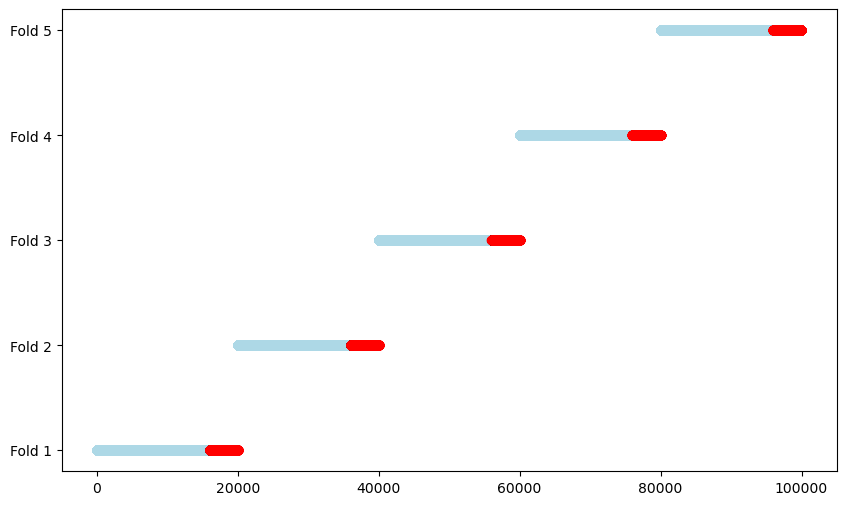

In [5]:
from timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [6]:
lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19977, 100, 3])
X2 shape: torch.Size([19977, 8])
y shape: torch.Size([19977, 1])


In [7]:
def run_optuna_study(objective_func, model_class, seed, X1, y, results_folder: str, n_trials: int = 100, num_epochs=500, X2=None):
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
    file_name = os.path.join(results_folder, "study.pkl")
    
    def objective(trial):
        criterion = torch.nn.MSELoss()  # Define the criterion here
        trial_val_loss, _, _ = objective_func(trial, seed, results_folder, model_class, X1, y, X2, criterion, num_epochs)  # Pass criterion

        return trial_val_loss

    # Let Optuna manage trials and pass them to the objective function
    study.optimize(objective, n_trials=n_trials)
    joblib.dump(study, file_name)
    study_df = study.trials_dataframe()
    study_df.to_csv(os.path.join(results_folder, "study_results.csv"), index=False)

    print("Best hyperparameters:", study.best_params)

Validation Losses [3.5434422492980957, 6.643298625946045, 7.077182769775391, 5.339697360992432, 5.630524158477783]
Mean validation loss: 5.64682903289795
Test Losses [5.260385990142822, 17.79901123046875, 17.152019500732422, 3.918377161026001, 11.176762580871582]
Mean test loss: 11.061311292648316
Mean test MAE: 1.6211824893951416
Mean test RMSE: 3.195319128036499


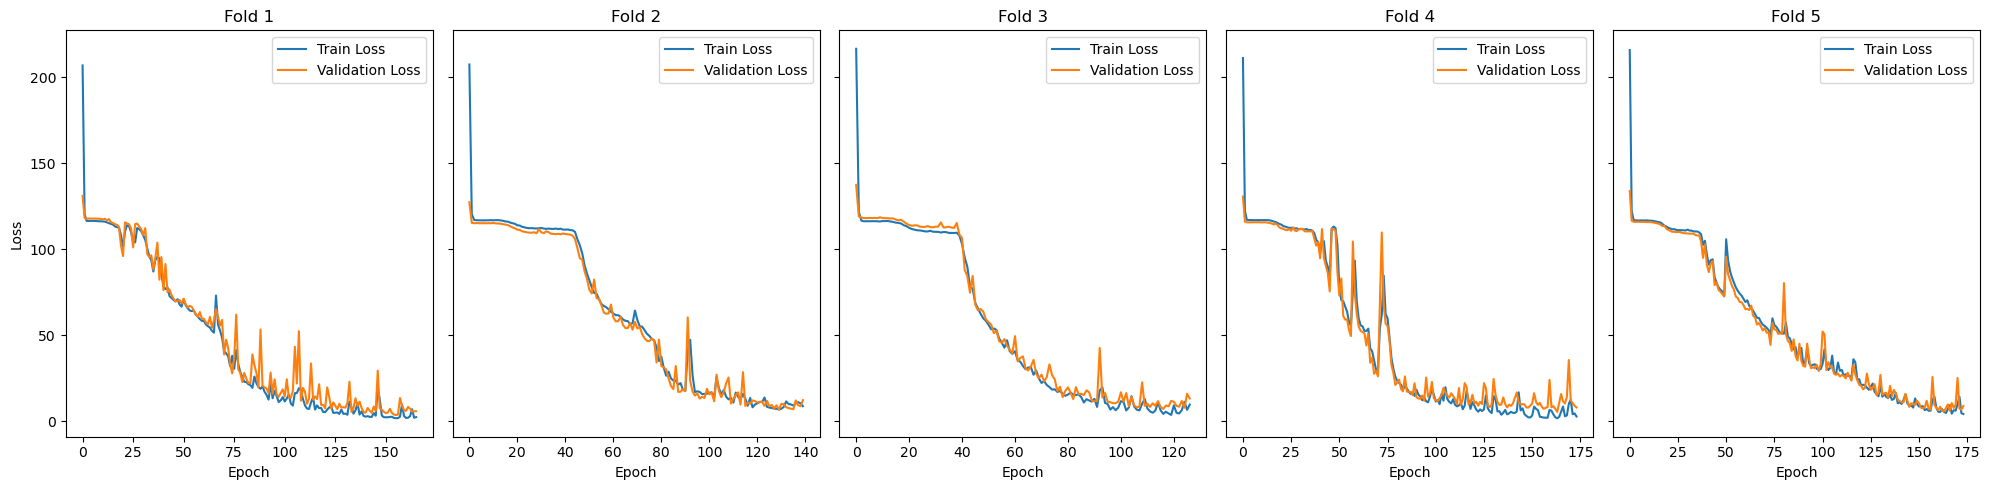

In [8]:
from models.lstm_pytorch import LSTMX1Input
from train_pipeline import EarlyStopper, ModelTrainingPipeline

n_trials = 100
num_epochs = 500

result_dir = os.path.join(results_dir, f"LSTMX1Input_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)


#run_optuna_study(pipeline.run_cross_val, LSTMX1Input, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
study_df = study.trials_dataframe()

print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
print("Test Losses", study.best_trial.user_attrs["test_losses"]) 
print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])


def plot_best_model_results(study_df):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

    best_fold_train_losses = []
    best_fold_val_losses = []

    for i in range(5):
        # Extract losses for the best trial for the current fold
        best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
        best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])

        # Plot train and validation losses in the current subplot
        axes[i].plot(best_fold_train_losses[i], label="Train Loss")
        axes[i].plot(best_fold_val_losses[i], label="Validation Loss")

        # Customize the subplot
        axes[i].set_title(f"Fold {i + 1}")
        axes[i].set_xlabel("Epoch")
        if i == 0:  # Only set ylabel for the first subplot
            axes[i].set_ylabel("Loss")
        axes[i].legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

plot_best_model_results(study_df)


Best hyperparameters: {'learning_rate': 0.0008396644664849787, 'hidden_size': 64, 'num_layers': 2, 'batch_size': 16}
Early stopping at epoch 166
Early stopping at epoch 140
Early stopping at epoch 127
Early stopping at epoch 174
Early stopping at epoch 174
Validation Losses: [3.5434422492980957, 6.643298625946045, 7.077182769775391, 5.339697360992432, 5.630524158477783]
Mean validation loss: 5.64682903289795
Test Losses: [5.260385990142822, 17.79901123046875, 17.152019500732422, 3.918377161026001, 11.176762580871582]
Mean test loss: 11.061311292648316


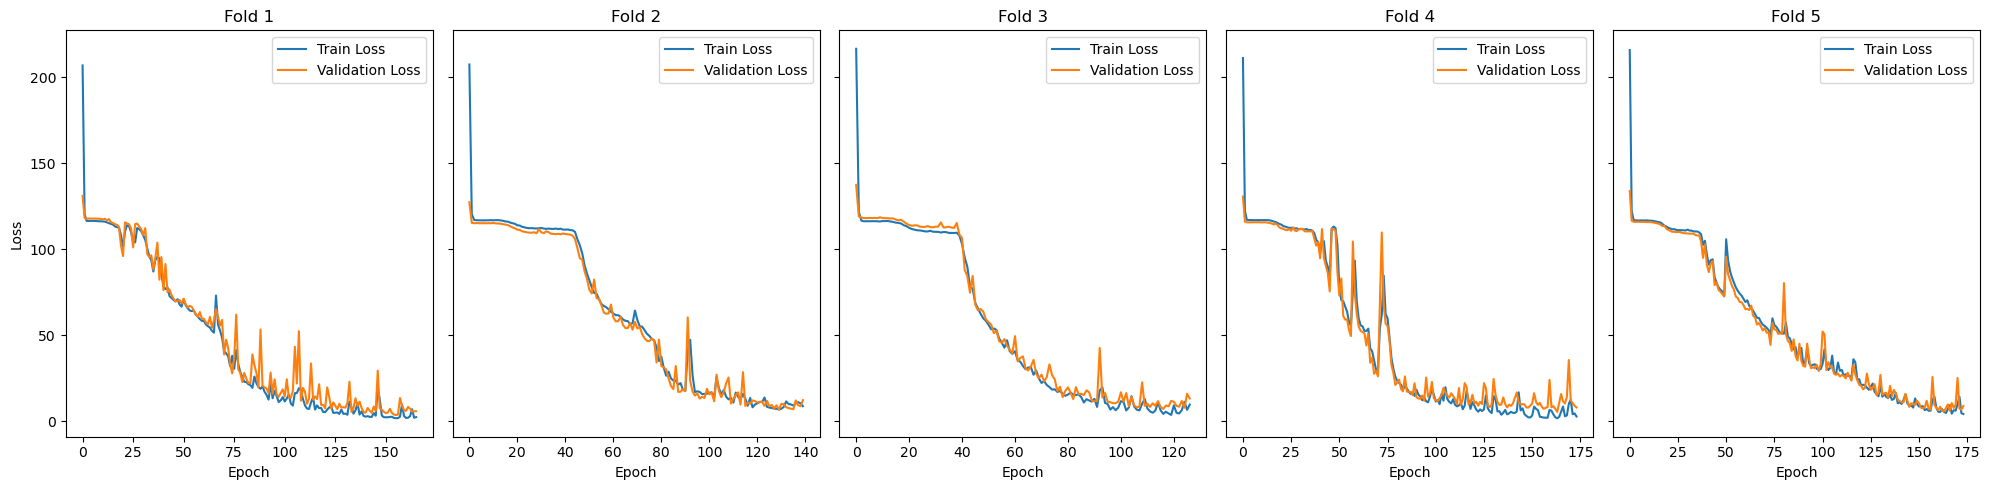

In [10]:
# Setting up the pipeline
pipeline = ModelTrainingPipeline(device=device, early_stopper=EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100))
ModelTrainingPipeline.set_seed(seed)

# Retrieve the best configuration from the Optuna study
best_config = study.best_params
print("Best hyperparameters:", best_config)

# Initialize lists to store results
epochs_train_losses = []
epochs_val_losses = []
val_losses = []
test_losses = []
all_predictions = []
all_true_values = []

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(BlockingTimeSeriesSplit(n_splits=5).split(X1)):
    pipeline.early_stopper.reset() 

    # Split data into train, validation, and test sets
    train_val_split_idx = int(0.8 * len(train_idx))
    train_idx, val_index = train_idx[:train_val_split_idx], train_idx[train_val_split_idx:]
    X1_train, X1_val, X1_test = X1[train_idx], X1[val_index], X1[test_idx]
    y_train, y_val, y_test = y[train_idx], y[val_index], y[test_idx]
    X1_train_scaled, X1_val_scaled, X1_test_scaled = pipeline.scale_data(X1_train, X1_val, X1_test)

    # Prepare data loaders
    train_loader, val_loader, test_loader = pipeline.prepare_dataloaders(
        X1_train_scaled, X1_val_scaled, X1_test_scaled, y_train, y_val, y_test,
        best_config["batch_size"]
    )

    # Initialize the model
    model = LSTMX1Input(
        input_size=X1.shape[2],
        hidden_size=best_config["hidden_size"],
        num_layers=best_config["num_layers"],
        output_size=1
    ).to(device)

    # Train the model
    fold_val_loss, model, train_losses, validation_losses = pipeline.train_model(
        model,
        criterion=torch.nn.MSELoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=best_config["learning_rate"]),
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=500,
        dual_input=False  # Single input configuration
    )

    # Store training and validation losses
    epochs_train_losses.append(train_losses)
    epochs_val_losses.append(validation_losses)
    val_losses.append(fold_val_loss)

    # Evaluate the model on the test set
    test_loss, fold_predictions, fold_true_values = pipeline.evaluate_test_set(
        model, test_loader, criterion=torch.nn.MSELoss(), dual_input=False
    )
    test_losses.append(test_loss)
    all_predictions.append(fold_predictions.cpu().numpy())
    all_true_values.append(fold_true_values.cpu().numpy())

# Output validation and test losses
print("Validation Losses:", val_losses)
print("Mean validation loss:", np.mean(val_losses))
print("Test Losses:", test_losses)
print("Mean test loss:", np.mean(test_losses))

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.show()






In [33]:
import plotly.graph_objects as go

# Example for one fold (extend to all folds if needed)
fig = go.Figure()
fig.add_trace(go.Scatter(y=np.ravel(all_true_values[0]), mode='markers', name='True Values'))
fig.add_trace(go.Scatter(y=np.ravel(all_predictions[0]), mode='markers', name='Predictions'))
fig.update_layout(
    title="Interactive Plot for Fold 1",
    xaxis_title="Sample",
    yaxis_title="Value"
)
fig.show()


[I 2024-12-02 17:01:36,576] A new study created in memory with name: no-name-c72e7b44-1d13-4cca-bac6-590ba632e488


Early stopping at epoch 121
Early stopping at epoch 311
Early stopping at epoch 306
Early stopping at epoch 195


[I 2024-12-02 17:07:46,002] Trial 0 finished with value: 4.251193368062377 and parameters: {'learning_rate': 2.6565450821928437e-05, 'hidden_size': 256, 'num_layers': 3, 'batch_size': 64}. Best is trial 0 with value: 4.251193368062377.


Early stopping at epoch 345


[I 2024-12-02 17:10:08,646] Trial 1 finished with value: 23.687231063842773 and parameters: {'learning_rate': 2.8519847491974242e-05, 'hidden_size': 64, 'num_layers': 1, 'batch_size': 64}. Best is trial 0 with value: 4.251193368062377.


Early stopping at epoch 235
Early stopping at epoch 197
Early stopping at epoch 231
Early stopping at epoch 202


[I 2024-12-02 17:17:40,152] Trial 2 finished with value: 0.3334445498883724 and parameters: {'learning_rate': 2.490743478997955e-05, 'hidden_size': 128, 'num_layers': 3, 'batch_size': 16}. Best is trial 2 with value: 0.3334445498883724.


Early stopping at epoch 148


[I 2024-12-02 17:23:39,713] Trial 3 finished with value: 5.844494915008545 and parameters: {'learning_rate': 1.3269220034595858e-05, 'hidden_size': 256, 'num_layers': 2, 'batch_size': 128}. Best is trial 2 with value: 0.3334445498883724.


Early stopping at epoch 203
Early stopping at epoch 284
Early stopping at epoch 203
Early stopping at epoch 276


[I 2024-12-02 17:24:48,917] Trial 4 finished with value: 14.724020862579346 and parameters: {'learning_rate': 0.0007721598996478031, 'hidden_size': 16, 'num_layers': 2, 'batch_size': 64}. Best is trial 2 with value: 0.3334445498883724.


Early stopping at epoch 192
Best hyperparameters: {'learning_rate': 2.490743478997955e-05, 'hidden_size': 128, 'num_layers': 3, 'batch_size': 16}
Configuration {'learning_rate': 2.490743478997955e-05, 'hidden_size': 128, 'num_layers': 3, 'batch_size': 16}
Validation Losses [0.04393268749117851, 0.15423071384429932, 0.05861765146255493, 0.11285823583602905, 1.2975834608078003]
Mean validation loss: 0.3334445498883724
Test Losses [0.20548298954963684, 16.752769470214844, 0.07194182276725769, 0.14258712530136108, 1.7613539695739746]
Mean test loss: 3.7868270754814146
Mean test MAE: 0.4939984560012817
Mean test RMSE: 1.3038608014583588


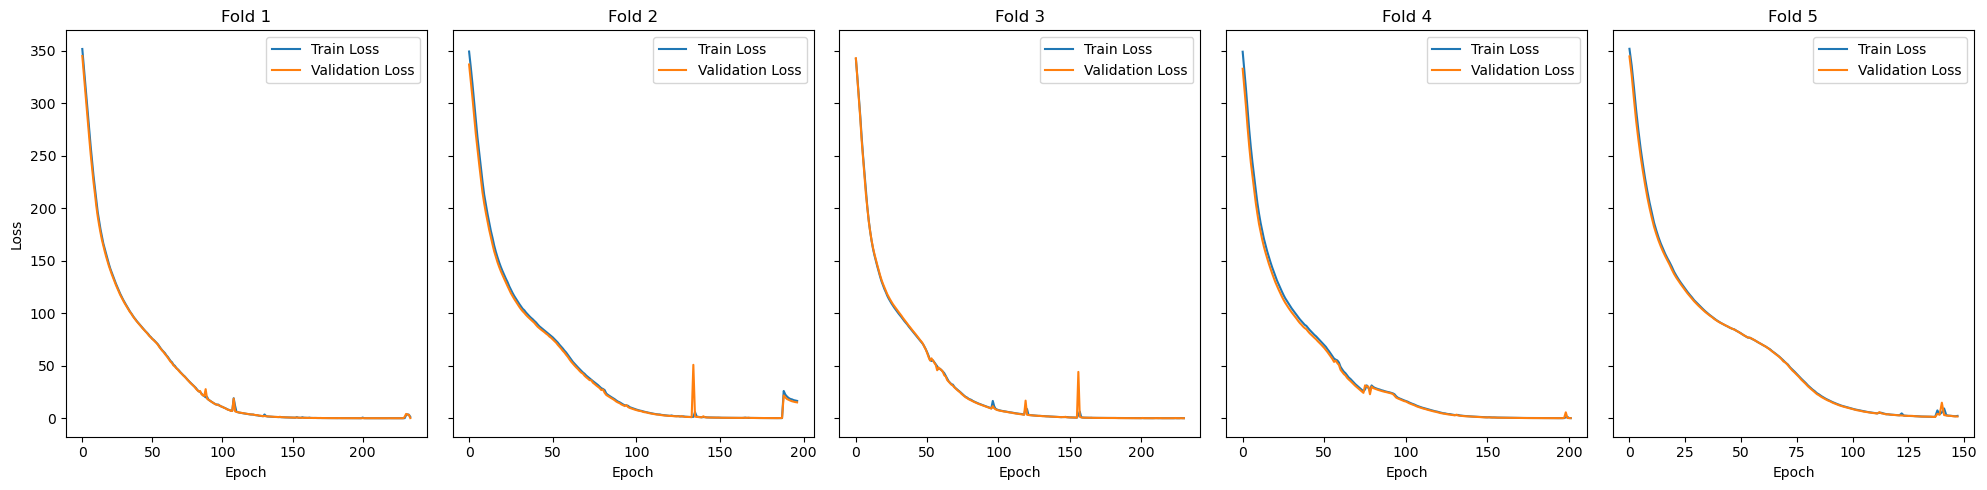

In [ ]:
from models.lstm_pytorch import LSTMX1_X2BeforeLSTM

n_trials = 100
num_epochs = 500

result_dir = os.path.join(results_dir, f"LSTMX1_X2BeforeLSTM_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

#run_optuna_study(run_cross_val, LSTMX1_X2BeforeLSTM, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs, X2=X2)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
study_df = study.trials_dataframe()

#best configuration
print("Configuration", study.best_trial.params)

print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
print("Test Losses", study.best_trial.user_attrs["test_losses"])
print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])

#get the best model results from study_df and for each fold plot the training loss
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

best_fold_train_losses = []
best_fold_val_losses = []

for i in range(5):
    # Extract losses for the best trial for the current fold
    best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
    best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])
    
    # Plot train and validation losses in the current subplot
    axes[i].plot(best_fold_train_losses[i], label="Train Loss")
    axes[i].plot(best_fold_val_losses[i], label="Validation Loss")
    
    # Customize the subplot
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# Adjust layout and display the plots
plt.tight_layout()
model_name = f"LSTMX1_X2BeforeLSTM_{n_trials}_trials_{num_epochs}_epochs"
plt.savefig(os.path.join(images_dir, f"{model_name}_training_loss.png"))
plt.show()

In [ ]:
from models.lstm_pytorch import LSTMX1_X2AfterLSTM

n_trials = 100
num_epochs = 500

result_dir = os.path.join(results_dir, f"LSTMX1_X2AfterLSTM_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(run_cross_val, LSTMX1_X2AfterLSTM, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs, X2=X2)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
study_df = study.trials_dataframe()

print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
print("Test Losses", study.best_trial.user_attrs["test_losses"])
print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])

#get the best model results from study_df and for each fold plot the training loss
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

best_fold_train_losses = []
best_fold_val_losses = []

for i in range(5):
    # Extract losses for the best trial for the current fold
    best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
    best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])
    
    # Plot train and validation losses in the current subplot
    axes[i].plot(best_fold_train_losses[i], label="Train Loss")
    axes[i].plot(best_fold_val_losses[i], label="Validation Loss")
    
    # Customize the subplot
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
from models.lstm_pytorch import LSTMX1_X2AfterLSTM

n_trials = 100
num_epochs = 500

result_dir = os.path.join(results_dir, f"LSTMX1_X2AfterLSTM_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(run_cross_val, LSTMX1_X2AfterLSTM, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs, X2=X2)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
study_df = study.trials_dataframe()

print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
print("Test Losses", study.best_trial.user_attrs["test_losses"])
print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])

#get the best model results from study_df and for each fold plot the training loss
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

best_fold_train_losses = []
best_fold_val_losses = []

for i in range(5):
    # Extract losses for the best trial for the current fold
    best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
    best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])
    
    # Plot train and validation losses in the current subplot
    axes[i].plot(best_fold_train_losses[i], label="Train Loss")
    axes[i].plot(best_fold_val_losses[i], label="Validation Loss")
    
    # Customize the subplot
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# Adjust layout and display the plots
plt.tight_layout()
model_name = f"LSTMX1_X2AfterLSTM_{n_trials}_trials_{num_epochs}_epochs"
plt.savefig(os.path.join(images_dir, f"{model_name}_training_loss.png"))
plt.show()


In [ ]:
from models.lstm_pytorch import LSTMX1_X2Masking

n_trials = 100
num_epochs = 500

#X1 shape is (num_samples, lookback_period)
masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx.item():idx.item()+p] = 1

masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)

result_dir = os.path.join(results_dir, f"LSTMX1_X2Masking_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(run_cross_val, LSTMX1_X2Masking, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs, X2=masking_X1)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
study_df = study.trials_dataframe()


print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
print("Test Losses", study.best_trial.user_attrs["test_losses"])
print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])

#get the best model results from study_df and for each fold plot the training loss
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

best_fold_train_losses = []
best_fold_val_losses = []

for i in range(5):
    # Extract losses for the best trial for the current fold
    best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
    best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])
    
    # Plot train and validation losses in the current subplot
    axes[i].plot(best_fold_train_losses[i], label="Train Loss")
    axes[i].plot(best_fold_val_losses[i], label="Validation Loss")
    
    # Customize the subplot
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# Adjust layout and display the plots
plt.tight_layout()
model_name = f"LSTMX1_X2Masking_{n_trials}_trials_{num_epochs}_epochs"
plt.savefig(os.path.join(images_dir, f"{model_name}_training_loss.png"))
plt.show()



In [ ]:
from models.lstm_pytorch import LSTMX1Attention

n_trials = 100
num_epochs = 500

result_dir = os.path.join(results_dir, f"LSTMX1Attention_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(run_cross_val, LSTMX1Attention, seed, X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
study_df = study.trials_dataframe()

print("Validation Losses", study.best_trial.user_attrs["fold_val_losses"])
print("Mean validation loss:", study.best_trial.user_attrs["mean_val_loss"])
print("Test Losses", study.best_trial.user_attrs["test_losses"]) 
print("Mean test loss:", study.best_trial.user_attrs["mean_test_loss"])
print("Mean test MAE:", study.best_trial.user_attrs["mean_test_mae"])
print("Mean test RMSE:", study.best_trial.user_attrs["mean_test_rmse"])

#get the best model results from study_df and for each fold plot the training loss
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)

best_fold_train_losses = []
best_fold_val_losses = []

for i in range(5):
    # Extract losses for the best trial for the current fold
    best_fold_train_losses.append(study_df[f"user_attrs_fold_{i + 1}_train_losses"].iloc[study_df["value"].idxmin()])
    best_fold_val_losses.append(study_df[f"user_attrs_fold_{i + 1}_validation_losses"].iloc[study_df["value"].idxmin()])
    
    # Plot train and validation losses in the current subplot
    axes[i].plot(best_fold_train_losses[i], label="Train Loss")
    axes[i].plot(best_fold_val_losses[i], label="Validation Loss")
    
    # Customize the subplot
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:  # Only set ylabel for the first subplot
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# Adjust layout and display the plots
plt.tight_layout()
model_name = f"LSTMX1Attention_{n_trials}_trials_{num_epochs}_epochs"
plt.savefig(os.path.join(images_dir, f"{model_name}_training_loss.png"))
plt.show()